In [1]:
import pandas as pd
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')

In [92]:
baseline_name = 'Water'

data = pd.read_csv('bandoro-microbiome.csv')

# Encode the "Sample" column with indices.
sample_names = dict()
for i, name in enumerate(sorted(np.unique(data['Sample'].values))):
    sample_names[name] = i

for name, i in sample_names.items():
    data['Indices'] = data['Sample'].apply(lambda x: sample_names[x])
    
data = data.sort('Indices')
    
    
baseline_idx = sample_names[baseline_name]
indices = list(set(data['Indices']))
indices.remove(baseline_idx)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [98]:
with pm.Model() as model:
    # Hyperpriors
    upper = pm.Exponential('upper', lam=0.05)
    # lower = pm.Exponential('lower', lam=1)

    # "fold", which is the estimated fold change.
    fold = pm.Uniform('fold', lower=1E-10, upper=upper, shape=len(sample_names))

    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    # sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    sigma = pm.HalfCauchy('sigma', beta=1, shape=len(sample_names))

    # Model prediction
    mu = fold[data['Indices']]
    sig = sigma[data['Indices']]

    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data['Normalized % GFP'])
    
    z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[indices, :] + 3 * sigma[baseline_idx]) / np.abs(fold[indices, :] - fold[baseline_idx]))

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [99]:
with model:
    n_steps = 100000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)


Iteration 0 [0%]: ELBO = -183283.36
Iteration 10000 [10%]: Average ELBO = -90538.04
Iteration 20000 [20%]: Average ELBO = -388.0
Iteration 30000 [30%]: Average ELBO = -288.53
Iteration 40000 [40%]: Average ELBO = -284.21
Iteration 50000 [50%]: Average ELBO = -282.82
Iteration 60000 [60%]: Average ELBO = -282.22
Iteration 70000 [70%]: Average ELBO = -281.28
Iteration 80000 [80%]: Average ELBO = -280.4
Iteration 90000 [90%]: Average ELBO = -280.06
Finished [100%]: Average ELBO = -279.94


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1206031d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x123cbb5c0>]], dtype=object)

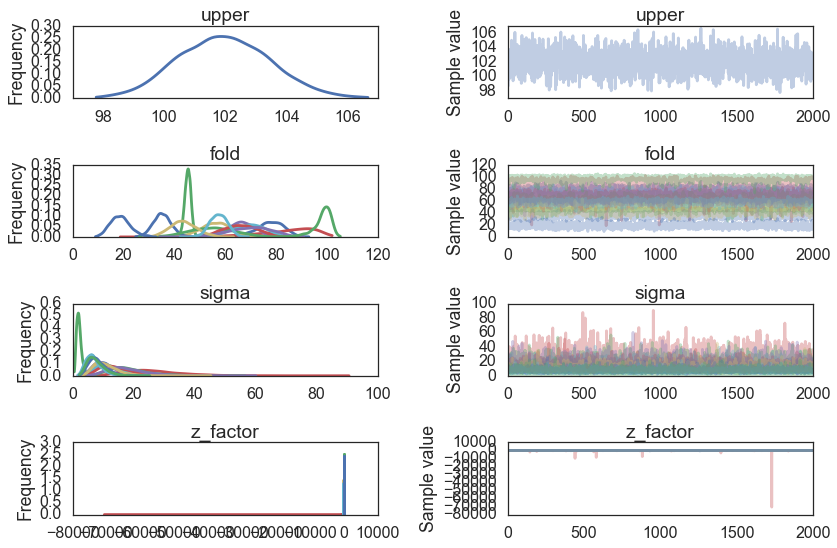

In [100]:
pm.traceplot(trace)

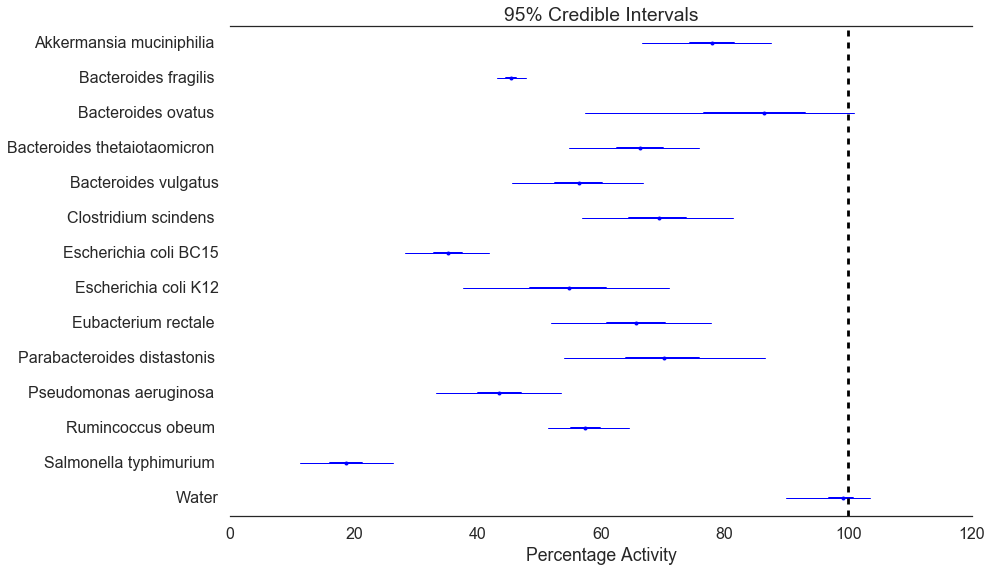

In [101]:
fig = plt.figure(figsize=(20, 8))
pm.forestplot(trace, varnames=['fold'], vline=100, ylabels=sorted(sample_names), xtitle='Percentage Activity', xrange=(0, 120))
plt.savefig('../figures/bandoro-microbiome-bayes.pdf', bbox_inches='tight')

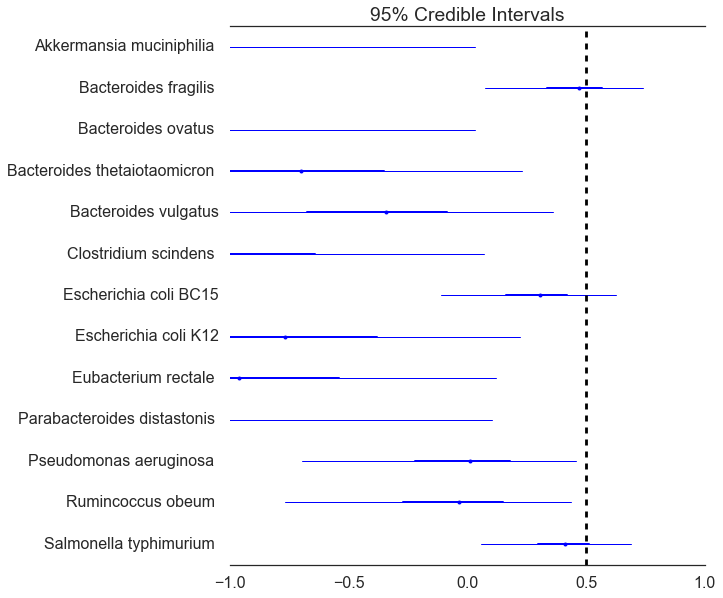

In [107]:
pm.forestplot(trace, varnames=['z_factor'], xrange=(-1, 1), vline=0.5, ylabels=sorted(set(sample_names).difference([baseline_name])))

In [86]:
trace.varnames

['upper', 'fold', 'sigma', 'z_factor']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x124919978>], dtype=object)

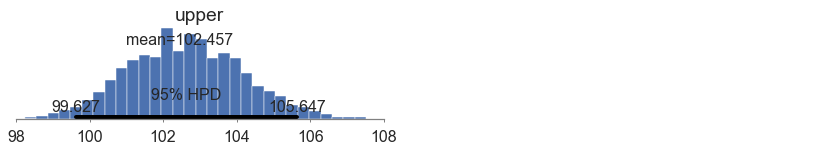

In [24]:
pm.plot_posterior(trace, varnames=['upper'], plot_transformed=True)

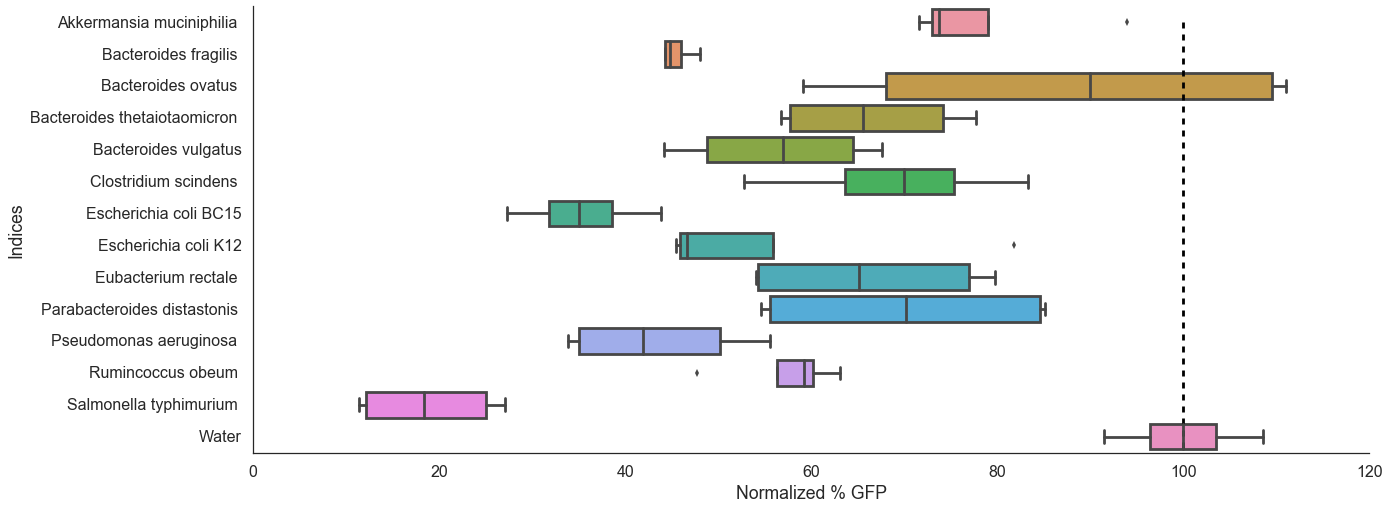

In [7]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
# data.plot(kind='scatter', y='Normalized % GFP', x='Indices', ax=ax)
# data.boxplot(column='Normalized % GFP', by='Indices', ax=ax)
sns.boxplot(data=data, y='Indices', x='Normalized % GFP', orient='h')
plt.yticks(range(len(sample_names)), sorted(sample_names))
ax.vlines(x=100, ymin=0, ymax=len(sample_names), linestyle='--')
sns.despine()
plt.savefig('../figures/bandoro-microbiome-data.pdf', bbox_inches='tight')

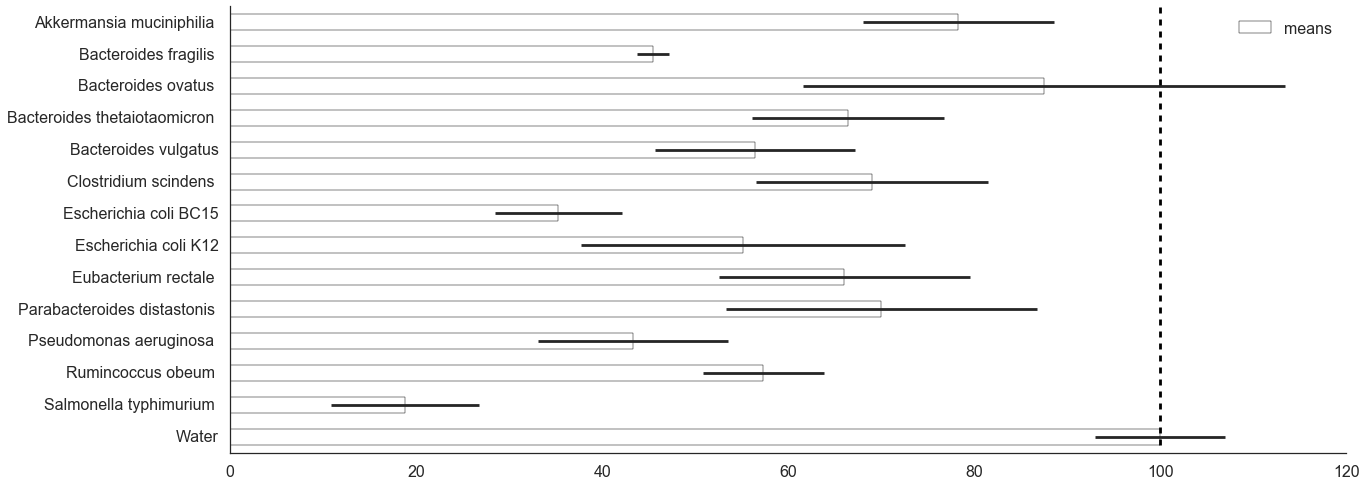

In [8]:
means = data.groupby('Indices').mean()['Normalized % GFP']
ci_width = data.groupby('Indices').std()['Normalized % GFP'] / np.sqrt(4)

freq_df = pd.DataFrame()
freq_df['means'] = data.groupby('Indices').mean()['Normalized % GFP']
freq_df['std'] = data.groupby('Indices').std()['Normalized % GFP']
freq_df['ci'] = freq_df['std'] / np.sqrt(4) * 1.96
freq_df.reset_index(inplace=True)
freq_df['Indices'] = np.abs(freq_df['Indices'] - len(freq_df)+1)
freq_df.sort('Indices').plot(kind='barh', x='Indices', y='means', xerr='ci', color='white', figsize=(20,8))

ax = plt.gca()
ax.set_yticklabels(sorted(sample_names, reverse=True))
ax.set_ylabel('')
ax.vlines(x=100, ymin=0-0.25, ymax=len(sample_names)-0.25, linestyle='--')

sns.despine()

plt.savefig('../figures/bandoro-microbiome-frequentist.pdf', bbox_inches='tight')

In [9]:
data.groupby('Sample').mean().sort('Normalized % GFP', ascending=False)

,% GFP,Normalized % GFP,Replicate,Indices
Sample,,,,
Water,20.0750,100.000000,2.5,13.0
Bacteroides ovatus,18.4425,87.525871,2.5,2.0
Akkermansia muciniphilia,15.9250,78.277791,2.5,0.0
Parabacteroides distastonis,14.6250,70.003415,2.5,9.0
Clostridium scindens,13.8875,68.996463,2.5,5.0
Bacteroides thetaiotaomicron,13.6750,66.386376,2.5,3.0
Eubacterium rectale,13.7150,66.034047,2.5,8.0
Rumincoccus obeum,11.6550,57.312946,2.5,11.0
Bacteroides vulgatus,11.6775,56.403161,2.5,4.0


In [10]:
means = trace['fold'].mean(axis=0)
mean_df = pd.DataFrame()
mean_df['means'] = means
mean_df['sample'] = sample_names
mean_df.sort('means', ascending=False)

,means,sample
13,98.098768,Water
2,83.595211,Rumincoccus obeum
0,77.946519,Bacteroides fragilis
9,70.235145,Bacteroides vulgatus
5,68.136540,Pseudomonas aeruginosa
3,66.306628,Bacteroides ovatus
8,65.907061,Parabacteroides distastonis
11,57.324146,Clostridium scindens
4,56.682897,Salmonella typhimurium
7,55.768841,Bacteroides thetaiotaomicron


In [11]:
freq_width = freq_df['ci'] * 2
data_range = data.groupby('Indices')['Normalized % GFP'].max() - data.groupby('Indices')['Normalized % GFP'].min()
bayes_low, bayes_high = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
bayes_range = bayes_high - bayes_low

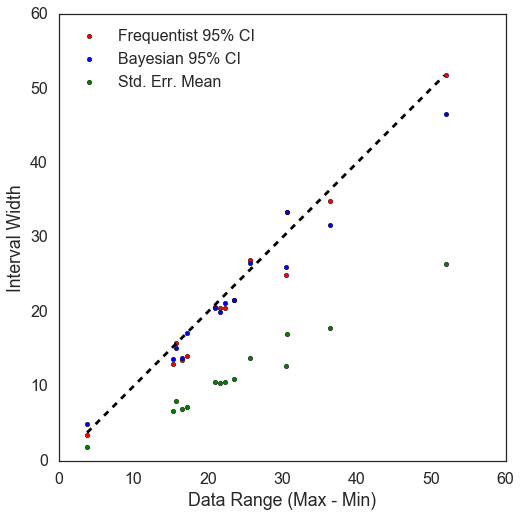

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

range_df = pd.DataFrame()
range_df['frequentist'] = freq_width
range_df['sem'] = freq_width / 1.96
range_df['data'] = data_range
range_df['bayesian'] = bayes_range
range_df.plot(kind='scatter', x='data', y='frequentist', ax=ax, color='red', label='Frequentist 95% CI')
range_df.plot(kind='scatter', x='data', y='bayesian', ax=ax, color='blue', label='Bayesian 95% CI')
range_df.plot(kind='scatter', x='data', y='sem', ax=ax, color='green', label='Std. Err. Mean')
plt.plot(np.arange(min(range_df['data']), max(range_df['data'])), np.arange(min(range_df['data']), max(range_df['data'])), color='black', linestyle='--')
plt.ylabel('Interval Width')
plt.xlabel('Data Range (Max - Min)')
plt.ylim(ax.get_xlim())


plt.savefig('../figures/bandoro-range-estimates.pdf', bbox_inches='tight')

In [27]:
out = pm.summary(trace)


upper:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  102.457          1.550            0.035            [99.627, 105.647]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  99.543         101.332        102.443        103.521        105.579


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  77.947           5.367            0.121            [67.314, 88.152]
  45.518           1.279            0.027            [42.914, 47.828]
  83.595           12.191           0.272            [58.942, 101.479]
  66.307           5.338            0.124            [55.653, 76.197]
  56.683           5.527            0.139            [46.741, 68.218]
  68.137           6.545            0.139     

In [29]:
pm.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
upper,102.456538,1.549887,0.035317,99.626776,105.646723
fold__0,77.946519,5.366545,0.120955,67.314132,88.152060
fold__1,45.518375,1.278925,0.027204,42.914021,47.828162
fold__2,83.595211,12.191071,0.271519,58.941839,101.478683
fold__3,66.306628,5.337908,0.124125,55.653382,76.196583
fold__4,56.682897,5.526798,0.138548,46.741379,68.217618
fold__5,68.136540,6.544511,0.139026,55.974361,81.511300
fold__6,35.412647,3.472962,0.074706,28.376846,41.749702
fold__7,55.768841,8.216810,0.187412,40.038463,71.692362
fold__8,65.907061,6.901565,0.140408,52.833194,79.098896


In [ ]:
pm.forestplot(trace, ylabels=)